In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.multivariate.pca import PCA
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from math import sqrt
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.api import VAR
import numpy as np
import seaborn as sns

from numpy import array
from numpy import hstack
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
from keras.layers import LeakyReLU

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
df = pd.read_csv("numerical_df_corrected.csv", index_col="Date")

In [ ]:
df.corr()['BIOGAS_PRODUCTION_Q_DAY'].abs().sort_values(ascending=False)

BIOGAS_PRODUCTION_Q_DAY                           1.000000
TPS_Q1_DAY                                        0.149911
PS_Q_DAY                                          0.148402
DIGESTED_SLUDGE_QOUT_DAY                          0.130412
DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEK    0.078733
TWAS_DAF_QIN_DAY                                  0.061662
Name: BIOGAS_PRODUCTION_Q_DAY, dtype: float64

In [ ]:
split_fraction = 0.8
train_split = int(split_fraction * int(df.shape[0]))
test_split = int((split_fraction+0.1) * int(df.shape[0]))
step = 1

past = 3
future = 1
learning_rate = 0.001
batch_size = 1
epochs = 100


def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

def smooth(dataset, train_split, smooth_level):
  for column in dataset.columns:
    data = dataset[column]
    exp = ExponentialSmoothing(data[:train_split])
    exp_model = exp.fit(smoothing_level=smooth_level)
    result = exp_model.fittedvalues
    dataset[column][:train_split] = result
    return dataset


In [ ]:
date_time_key = "Date"
print(
    "The selected parameters are:",
    ", ".join([df.columns[i] for i in [0, 1, 2, 3, 4, 5]]),
)
cols = [df.columns[i] for i in [0, 1, 2, 3, 4, 5]]
selected_features = [df.columns[i] for i in [0, 1, 2, 3, 4, 5]]
features = df[selected_features]
features.set_index(df.index, inplace=True)
#print(features.head())

features = smooth(features, train_split, smooth_level=0.1)
#print(features.head())

#features = normalize(features.values, train_split)
features = pd.DataFrame(features.values)
#print(features.head())



train_data = features.loc[0 : train_split - 1]
test_data = features.loc[train_split:test_split-1]
val_data = features.loc[test_split:]

The selected parameters are: PS_Q_DAY, TPS_Q1_DAY, TWAS_DAF_QIN_DAY, DIGESTED_SLUDGE_QOUT_DAY, BIOGAS_PRODUCTION_Q_DAY, DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEK


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
start = past + future
end = start + train_split

x_train = train_data[[0, 1, 2, 3, 5]].values
y_train = features.iloc[start:end][[4]]

sequence_length = int(past / step)

In [ ]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [ ]:
x_end = len(val_data) - past - future

label_start = test_split + past + future

x_val = val_data.iloc[:x_end][[0,1,2,3,5]].values
y_val = features.iloc[label_start:][[4]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

x_end = len(test_data) - past - future

label_start = test_split + past + future

x_test = test_data.iloc[:x_end][[0,1,2,3,5]].values
y_test = features.iloc[label_start:][[4]]

dataset_test = keras.preprocessing.timeseries_dataset_from_array(
    x_test,
    y_test,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (1, 3, 5)
Target shape: (1, 1)


In [ ]:
# DISCRETE MODEL
inputs = Input(shape=(inputs.shape[1], inputs.shape[2]))
#lstm_out = keras.layers.LSTM(32)(inputs,
lrelu = lambda x: tf.keras.layers.LeakyReLU(alpha=0.1)(x)
cnn = Conv1D(filters=32, kernel_size=1, activation=lrelu)(inputs)
cnn = Conv1D(filters=64, kernel_size=1, activation=lrelu)(cnn)
#cnn = MaxPooling1D(pool_size=2)(cnn)
#cnn = Conv1D(filters=32, kernel_size=1, activation=lrelu)(cnn)

cnn = Flatten()(cnn)

dense = Dense(50, activation=lrelu)(cnn)
output = Dense(1)(dense)

model = keras.Model(inputs=inputs, outputs=output)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 1, 5)]            0         
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 1, 32)             192       
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 1, 64)             2112      
_________________________________________________________________
flatten_13 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 50)                3250      
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 51        
Total params: 5,605
Trainable params: 5,605
Non-trainable params: 0
________________________________________________________

In [ ]:
# TIME SERIES MODEL
inputs = Input(shape=(inputs.shape[1], inputs.shape[2]))
#lstm_out = keras.layers.LSTM(32)(inputs,
lrelu = lambda x: tf.keras.layers.LeakyReLU(alpha=0.1)(x)
cnn = Conv1D(filters=32, kernel_size=2, activation=lrelu)(inputs)
cnn = Conv1D(filters=64, kernel_size=2, activation=lrelu)(cnn)
#cnn = MaxPooling1D(pool_size=2)(cnn)
#cnn = Conv1D(filters=32, kernel_size=1, activation=lrelu)(cnn)

cnn = Flatten()(cnn)

dense = Dense(50, activation=lrelu)(cnn)
output = Dense(1)(dense)

model = keras.Model(inputs=inputs, outputs=output)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 3, 5)]            0         
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 2, 32)             352       
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 1, 64)             4160      
_________________________________________________________________
flatten_15 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 50)                3250      
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 51        
Total params: 7,813
Trainable params: 7,813
Non-trainable params: 0
________________________________________________________

In [ ]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/100
678/678 [==============================] - 2s 3ms/step - loss: 0.5467 - val_loss: 0.7389

Epoch 00001: val_loss improved from inf to 0.73895, saving model to model_checkpoint.h5
Epoch 2/100
678/678 [==============================] - 2s 3ms/step - loss: 0.5169 - val_loss: 0.5845

Epoch 00002: val_loss improved from 0.73895 to 0.58449, saving model to model_checkpoint.h5
Epoch 3/100
678/678 [==============================] - 2s 3ms/step - loss: 0.5211 - val_loss: 0.5894

Epoch 00003: val_loss did not improve from 0.58449
Epoch 4/100
678/678 [==============================] - 2s 3ms/step - loss: 0.5261 - val_loss: 0.5645

Epoch 00004: val_loss improved from 0.58449 to 0.56449, saving model to model_checkpoint.h5
Epoch 5/100
678/678 [==============================] - 2s 3ms/step - loss: 0.5598 - val_loss: 0.4971

Epoch 00005: val_loss improved from 0.56449 to 0.49711, saving model to model_checkpoint.h5
Epoch 6/100
678/678 [==============================] - 2s 3ms/step - loss: 

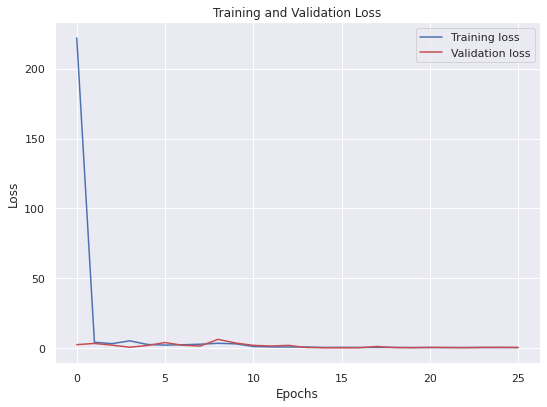

In [ ]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, f"Mean Square Error {model_type[-1]} QCNN Model")

In [ ]:

def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.ylim([0, 5])
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

errors = []
actual = []
predicted = []

for x, y in dataset_val.take(100):
    show_plot(
        [x[0][:, 4].numpy(), y[0].numpy(), model.predict(x)[0]],
        1,
        "Single Step Prediction",
    )




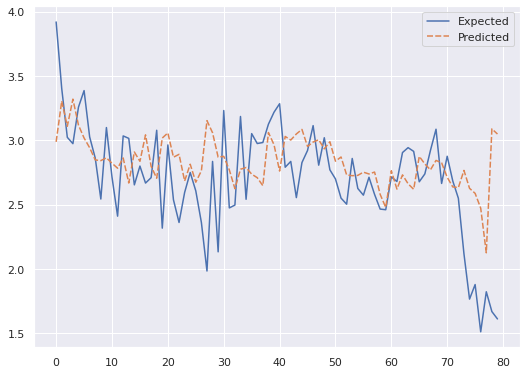

In [ ]:
results = pd.DataFrame(columns=["Expected", "Predicted"])#"Expected_Trend", "Predicted_Trend"])
results["Expected"] = actual
#results["Expected_Trend"] = results['Expected'].rolling(3).mean()

results["Predicted"] = predicted
#results["Predicted_Trend"] = results['Predicted'].rolling(3).mean()

#plt.ylim(0,5)
sns.set(rc={'figure.figsize':(8.7,6.27)})
sns.lineplot(data=results,palette="deep")#, label="Predictions")
#sns.lineplot(data = expected)#, label="Actual")

In [ ]:
errors = np.array(errors)
mape = np.mean(np.abs(errors)/actual)
rmse = np.sqrt(np.mean((np.square(errors))))
rmse_percent = rmse/np.mean(actual)
mae = np.mean(np.abs(errors))
mae_percent = np.mean(np.abs(errors))/np.mean(actual)


accuracy = 100 - 100*mape
print(f"MAPE = {mape}")
print('Accuracy:', round(accuracy, 2), '%.')
print(f"RMSE: {rmse}")
print(f"RMSE%: {rmse_percent}")
print(f"MAE: {mae}")
print(f"MAE%: {mae_percent}")
# Window = 1

MAPE = 0.12740013492640345
Accuracy: 87.26 %.
RMSE: 0.41807010950721873
RMSE%: 0.15411728626069054
MAE: 0.29838006560802455
MAE%: 0.10999477106841939
